<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D1%82%D1%81%D0%BB%D0%B5%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D1%83%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отслеживание рук

# Hand tracking

В этом уроке мы будем отслеживать движение рук. Для этого будем использовать уже знакомый нам opencv и новую библиотеку medipipe.

In this tutorial, we will be tracking hand movements. To do this, we will use the already familiar opencv and the new medipipe library.

> **Mediapipe** имеет много готовых встроенных решений комьютерного зрения для разнообразных задач. has many ready-made built-in computer vision solutions for a variety of tasks.

**MediaPipe Hands** использует конвейер машинного обучения, состоящий из нескольких моделей, работающих вместе: модель обнаружения ладони, которая работает с полным изображением и возвращает ориентированную ограничивающую рамку руки.
Модель ориентира руки, которая работает с обрезанной областью изображения, определенной детектором ладони, и возвращает точные трехмерные ключевые точки руки. После обнаружения ладони по всему изображению, наша последующая модель ориентира руки выполняет точную локализацию 21 ключевой точки суставов руки внутри обнаруженных областей рук по трём координатам.

**MediaPipe Hands** uses a machine learning pipeline of several models working together: a palm detection model that operates on a full image and returns an oriented bounding box of the hand.
A hand landmark model that works with the cropped area of ​​the image detected by the palm detector and returns accurate 3D key points of the hand. After detecting the palm over the entire image, our subsequent model of the hand landmark performs accurate localization of 21 key points of the joints of the hand within the detected areas of the hands in three coordinates.

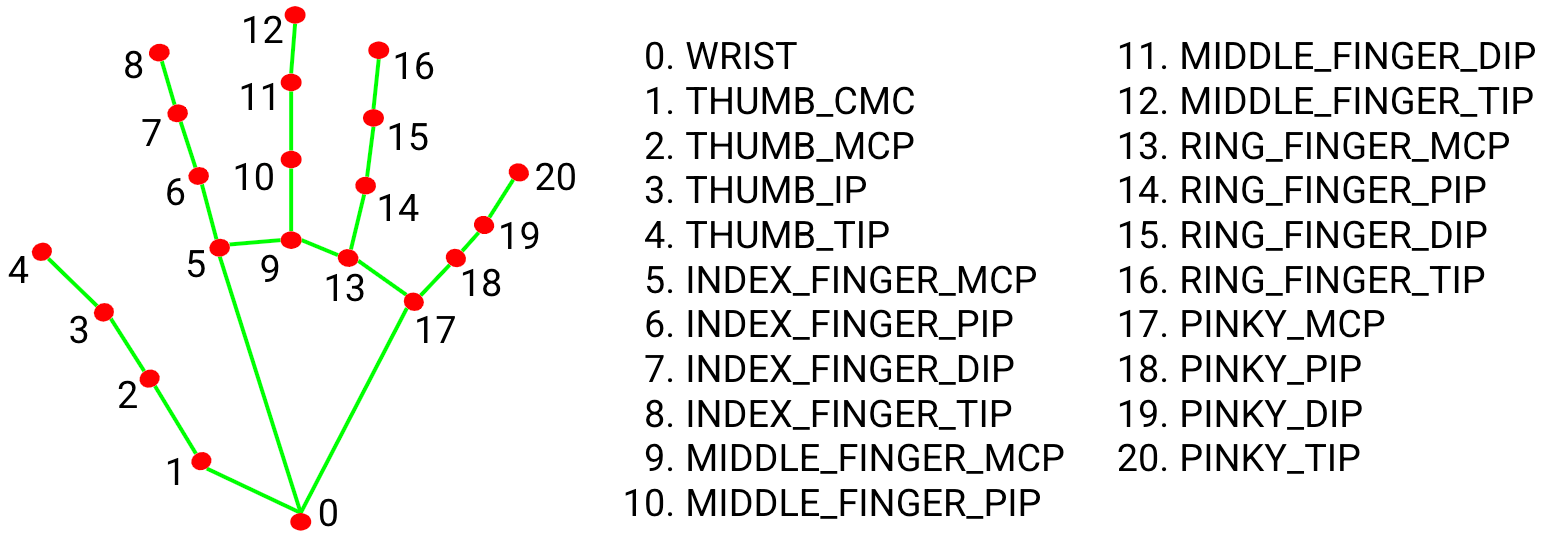

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_45.HandTracking.zip
!unzip Lesson_45.HandTracking.zip
%cd /content/Lesson_45.HandTracking

--2022-02-08 16:28:02--  http://dataudt.ru/datasets/cv/Lesson_45.HandTracking.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8905102 (8.5M) [application/zip]
Saving to: ‘Lesson_45.HandTracking.zip’

Lesson_45.HandTrack 100%[===================>]   8.49M  7.49MB/s    in 1.1s    

2022-02-08 16:28:04 (7.49 MB/s) - ‘Lesson_45.HandTracking.zip’ saved [8905102/8905102]

Archive:  Lesson_45.HandTracking.zip
   creating: Lesson_45.HandTracking/
  inflating: Lesson_45.HandTracking/HandTrackingMinimum.py  
  inflating: Lesson_45.HandTracking/HandTrackingModule.py  
  inflating: Lesson_45.HandTracking/readme.txt  
   creating: Lesson_45.HandTracking/Videos/
  inflating: Lesson_45.HandTracking/Videos/ex1.mp4  
  inflating: Lesson_45.HandTracking/Videos/ex2.mp4  
  inflating: Lesson_45.HandTracking/Videos/ex3.mp4  
/content/Lesson_45.HandTracking


In [2]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.4 MB/s 


In [3]:
# импортируем необходимые модули
# import the required modules
import cv2
import mediapipe as mp
import time

Детектор **mediapipe** по умолчанию принимает такие параметры:
(static_image_mode=False, max_num_hands=2,min_detection_confidence=0.5, min_tracking_confidence=0.5), где: 

The ** mediapipe ** detector accepts the following parameters by default:
(static_image_mode = False, max_num_hands = 2, min_detection_confidence = 0.5, min_tracking_confidence = 0.5), where:

- `STATIC_IMAGE_MODE`

    Если установлено false, решение обрабатывает входные изображения как видеопоток. Детектор попытается обнаружить руки на первых входных изображениях и после успешного обнаружения локализует ориентиры рук. В последующих изображениях, как только все руки обнаружены и соответствующие ориентиры рук локализованы, он просто отслеживает эти ориентиры, не вызывая другое обнаружение, пока не потеряет отслеживание любой из рук. Это уменьшает задержку и идеально подходит для обработки видеокадров. Если установлено значение true, обнаружение рук запускается для каждого входного изображения, что идеально подходит для обработки пакета статических, возможно, несвязанных изображений. По умолчанию false.

    If set to false, the solution treats the input images as a video stream. The detector will try to detect hands in the first input images and, after successful detection, localizes the landmarks of the hands. In the subsequent images, once all the hands are detected and the corresponding hand landmarks are located, it simply tracks those landmarks without triggering another detection until it loses track of either hand. This reduces latency and is ideal for processing video frames. If set to true, hand detection is triggered on every input image, ideal for handling a batch of static, possibly unrelated images. The default is false.

- `MAX_NUM_HANDS`

    Максимальное количество рук для обнаружения. По умолчанию 2.

    The maximum number of hands to detect. The default is 2.

- `MIN_DETECTION_CONFIDENCE`

    Минимальное значение достоверности 0 до 1 для модели обнаружения рук, чтобы обнаружение считалось успешным. По умолчанию 0.5.

    The minimum confidence value is 0 to 1 for the hand detection model for the detection to be considered successful. The default is 0.5.

- `MIN_TRACKING_CONFIDENCE`

    Минимальное значение достоверности 0 до 1 для модели отслеживания ориентиров, чтобы ориентиры рук считались отслеженными успешно, в противном случае обнаружение рук будет автоматически вызываться на следующем входном изображении. Установка более высокого значения может повысить надежность решения за счет увеличения задержки. Игнорируется, если static_image_mode равен true, когда обнаружение рук просто запускается на каждом изображении. По умолчанию 0.5.

    The minimum confidence value is 0 to 1 for the landmark tracking model for hand landmarks to be considered successfully tracked, otherwise hand detection will be automatically triggered on the next input image. Setting a higher value can improve the reliability of the solution by increasing the latency. Ignored if static_image_mode is true when hand detection is simply triggered on each image. The default is 0.5.

In [4]:
# создаём класс детектора рук
# create a hand detector class
class handDetector():
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        # режим работы
        # operating mode
        self.mode = mode
        # максимальное количество рук
        # maximum number of hands
        self.maxHands = maxHands
        # значение достоверности обноружения рук
        # value of reliability of hand detection
        self.detectionCon = detectionCon
        # значение достоверности отслеживания ориентиров
        # credibility value for landmark tracking
        self.trackCon = trackCon

        # инициазируем детектор рук mediapipe
        # initiate the mediapipe hand detector
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode,
                                    self.maxHands,
                                    self.detectionCon,
                                    self.trackCon)

        # инструменты для отрисовки сети ориентиров
        # tools for drawing a network of landmarks
        self.mpDraw = mp.solutions.drawing_utils

    # находим и рисуем сеть ориентиров
    # find and draw a network of landmarks
    def findHands(self, img, draw=True):
        # opencv по умолчанию сохраняет изображения
        # в формате каналов цвета BGR
        # конвертируем в стандартный формат RGB
        # opencv saves images by default
        # in BGR color channel format
        # convert to standard RGB format
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # детектор обрабатывает изображение и возвращает нам результат
        # нам не нужно дополнительно ничего знать, всё сделает за нас библиотека
        # the detector processes the image and returns the result to us
        # we don't need to know anything additionally, the library will do everything for us
        self.results = self.hands.process(imgRGB)

        # если мы обнаружили ладонь/руку
        #if we find a palm / hand
        if self.results.multi_hand_landmarks:
            # тогда для каждой ладони/руки
            # then for each palm / hand
            for hadsLms in self.results.multi_hand_landmarks:
                if draw:
                    # рисуем точки и соединения на изображении
                    # draw points and connections on the image
                    self.mpDraw.draw_landmarks(img, hadsLms, self.mpHands.HAND_CONNECTIONS)

        # возвращаем изображение с нарисованной сетью ориентиров
        # return an image with a drawn grid of landmarks
        return img

    # находим координаты каждой точки на сети
    # find the coordinates of each point on the network
    def findPosition(self, img, handNo=0, draw=True):

        # создаём список координат
        # create a list of coordinates
        lmList = []

        # если мы обнаружили ладонь/руку
        #if we find a palm / hand
        if self.results.multi_hand_landmarks:
            # выбираем сеть точек необходимой руки
            # для этого указываем номер руки
            # select the network of points of the required hand
            # for this we indicate the hand number
            myHand = self.results.multi_hand_landmarks[handNo]

            # берём каждую точку на ориентирах от 0 до 20
            # take each point on landmarks from 0 to 20
            for id, lm in enumerate(myHand.landmark):
                # и выведем номер и координаты каждой точки
                # and display the number and coordinates of each point

                # каждая точка имеет id и 3 координаты x, y и z
                # координаты нормированы  от 0 до 1
                # оносительно ширины и высоты изображения
                # each point has an id and 3 coordinates x, y and z
                # coordinates are normalized from 0 to 1
                # about the width and height of the image

                # высота, ширина и количество каналов изображения
                # height, width and number of image channels
                h, w, с = img.shape

                # чтобы получить координаты в пикселях умножим их
                # на ширину и высоту изображения соответственно
                # to get coordinates in pixels we multiply them
                # for the width and height of the image, respectively
                cx, cy = int(lm.x * w), int(lm.y * h)

                # добавляем координаты в список
                # add coordinates to the list
                lmList.append([id, cx, cy])

                # рисуем каждую точку
                # draw each point
                if draw:
                    cv2.circle(img, (cx, cy), 7, (255, 0, 255), cv2.FILLED)

        # возвращаем список координат 
        # return a list of coordinates
        return lmList

In [5]:

# инициализируем захват с видео
# initialize capture from video
cap = cv2.VideoCapture("Videos/ex2.mp4")
# инициазируем детектор рук
# initiate the hand detector
mpHands = mp.solutions.hands
hands = mpHands.Hands() 

# инструменты для отрисовки сети ориентиров
# tools for drawing a network of landmarks
mpDraw = mp.solutions.drawing_utils

# переменные для расчёта fps
# variables for calculating fps
# предыдущее время 
# previous time
pTime = 0 
# текущее время 
# current time
cTime = 0  

writer = None
# бесконечный цикл
# endless cycle
while True:
    # считываем изображение с камеры
    # read the image from the camera
    success, img = cap.read()
    if not success:
        break
    # opencv по умолчанию сохраняет изображения
    # в формате каналов цвета BGR
    # конвертируем в стандартный формат RGB
    # opencv saves images by default
    # in BGR color channel format
    # convert to standard RGB format
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    # детектор обрабатывает изображение и возвращает нам результат
    # нам не нужно дополнительно ничего знать, всё сделает за нас библиотека
    # the detector processes the image and returns the result to us
    # we don't need to know anything additionally, the library will do everything for us
    results = hands.process(imgRGB)

    # если мы обнаружили ладонь/руку
    #if we find a palm / hand
    if results.multi_hand_landmarks:
        # тогда для каждой ладони/руки
        # then for each palm / hand
        for handLms in results.multi_hand_landmarks:
            # берём каждую точку на ориентирах от 0 до 20
            # take each point on landmarks from 0 to 20
            for id, lm in enumerate(handLms.landmark):
                # и выведем номер и координаты каждой точки
                # and display the number and coordinates of each point

                # каждая точка имеет id и 3 координаты x, y и z
                # координаты нормированы  от 0 до 1
                # относительно ширины и высоты изображения
                # each point has an id and 3 coordinates x, y and z
                # coordinates are normalized from 0 to 1
                # relative to image width and height

                # высота, ширина и количество каналов изображения
                # height, width and number of image channels
                h, w, с = img.shape

                # чтобы получить координаты в пикселях умножим их
                # на ширину и высоту изображения соответственно
                # to get coordinates in pixels we multiply them
                # for the width and height of the image, respectively
                cx, cy = int(lm.x * w), int(lm.y * h)
                # выведем номер точки и её координаты в пикселях
                # output the point number and its coordinates in pixels
                print(id, cx, cy)
                
                # выделим для примера большой палец
                # для этого нарисуем круг побольше
                # select the thumb for example
                # for this we draw a larger circle
                if id == 4:
                    cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

            # рисуем точки и соединения на изображении
            # draw points and connections on the image
            mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)
                
    # расчитываем fps
    # calculate fps
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    # и выводим его на экран
    # and display it on the screen
    cv2.putText(img, str(int(fps)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 3)

    # проверяем, не подключено ли видеозаписывающее устройство 
    # проверяем, существует ли уже VideoWriter, который записывает наше новое видео 
    # check if a video recorder is connected
    # check if there is already a VideoWriter that writes our new video
    if writer is None:
    # если нет, то настроим его под нас (указываем в каком формате и куда мы это все будем сохранять) 
    # if not, then set it up for us (indicate in what format and where we will save it all)
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("output.avi", fourcc, 30,
            (img.shape[1], img.shape[0]), True)

    # записываем выходной кадр на диск
    # write the output frame to disk
    writer.write(img)

writer.release()

Выходные данные были обрезаны до нескольких последних строк (5000).
19 92 443
20 121 443
0 750 648
1 644 649
2 566 608
3 510 555
4 482 507
5 588 494
6 527 422
7 498 397
8 476 386
9 644 458
10 576 382
11 536 357
12 509 352
13 694 446
14 644 368
15 610 339
16 578 335
17 734 450
18 712 383
19 687 351
20 661 338
0 98 748
1 199 710
2 268 641
3 301 554
4 302 488
5 194 543
6 241 451
7 272 429
8 291 431
9 128 525
10 191 438
11 229 441
12 250 458
13 78 526
14 129 439
15 172 431
16 197 443
17 40 537
18 63 461
19 97 446
20 122 450
0 755 647
1 649 651
2 570 612
3 513 559
4 484 509
5 592 494
6 526 423
7 495 404
8 476 403
9 648 457
10 572 378
11 532 355
12 505 353
13 696 444
14 636 368
15 599 344
16 569 346
17 735 448
18 704 381
19 674 351
20 646 343
0 95 747
1 199 711
2 268 647
3 304 569
4 308 506
5 197 542
6 244 445
7 277 420
8 299 419
9 132 526
10 192 431
11 231 431
12 253 446
13 83 528
14 129 436
15 171 429
16 195 442
17 44 540
18 68 463
19 103 449
20 128 455
0 759 651
1 653 650
2 575 608
3 516 

Будем работать по следующему принципу:
- получаем видео в формате avi
- конвертирую его в mp4 
- воспроизводим с помощью модуля kora

We will work according to the following principle:
- we get video in avi format
- convert it to mp4
- reproducible using the kora module

In [6]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [7]:
!pip install -U kora

     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 


In [8]:
from kora.drive import upload_public
url = upload_public('output.mp4')

from IPython.display import HTML
HTML(f"""<video src={url} width=640 controls/>""")